In [ ]:
# pip install xgboost

In [184]:
from pytqs import tqs
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from datetime import date, timedelta
import datetime; 

from sklearn import neighbors
from sklearn.neighbors import NearestNeighbors
from sklearn.neighbors import KDTree

from sklearn.metrics import precision_recall_curve
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
import statsmodels.api as sm
from sklearn.datasets import make_regression
from sklearn.ensemble import RandomForestRegressor
from matplotlib import pyplot
from xgboost import XGBRegressor

import bytedtqs

In [150]:
# appId = "eL38NWjpAMXlC0ifCoo71wk27zE6CS9YQismEcwVH5oNKbJf"
# appKey = "VeeOKtXLxjGWE2OyIGkuqWRT33isyxtHH1xlxakeFzId6SMB"
# user_id = 'wuweiwei.1012'

## 获取原始数据

In [174]:
all_data = pd.read_csv('/home/tiger/archived-data/aeolus-data/20210318/17/40347479-配音-内容质量研究-查询15.csv', encoding = 'gb18030')
all_data.head()

,user_id,item_id,date,start_flag,finish_flag,score,user_level_id,vip_flag,new_user_flag,lesson_level_id,type,lesson_name,lesson_duration,lesson_words
0,14404904910,6916410888987656455,20210220,1,0,NaN,5.0,1.0,0.0,5.0,欧美剧集,谢耳朵的日记,28166.0,48.0
1,93241095354,6916102435383591176,20210211,0,0,NaN,3.0,1.0,0.0,3.0,欧美剧集,为约会漂白牙齿,58724.0,110.0
2,93241095354,6917068156628369671,20210211,0,0,NaN,3.0,1.0,0.0,1.0,经典动画,早安呀我的好朋友,12314.0,26.0
3,93241095354,6916453168800907533,20210211,1,0,NaN,3.0,1.0,0.0,3.0,经典动画,一起堆雪人,48321.0,51.0
4,93241095354,6917087207845019918,20210211,0,0,NaN,3.0,1.0,0.0,3.0,名人演讲,爱是耐心 爱是善良,30106.0,44.0


In [175]:
len(all_data)

897176

### 数据预处理

In [176]:
# str fill 
str_var = ['type']
all_data[str_var] = all_data[str_var].fillna('未知')

# number fill
num_var = ['user_level_id', 'vip_flag', 'new_user_flag', 'lesson_level_id', 'lesson_duration', 'lesson_words']
all_data[num_var] = all_data[num_var].fillna(-1)

all_data.loc[(all_data['user_level_id'] == all_data['lesson_level_id']), 'level_match'] = 1
all_data.loc[(all_data['user_level_id'] != all_data['lesson_level_id']), 'level_match'] = 0

all_data['density'] = all_data['lesson_words'] / all_data['lesson_duration'] * 1000

all_data.head()

,user_id,item_id,date,start_flag,finish_flag,score,user_level_id,vip_flag,new_user_flag,lesson_level_id,type,lesson_name,lesson_duration,lesson_words,level_match,density
0,14404904910,6916410888987656455,20210220,1,0,NaN,5.0,1.0,0.0,5.0,欧美剧集,谢耳朵的日记,28166.0,48.0,1.0,1.704182
1,93241095354,6916102435383591176,20210211,0,0,NaN,3.0,1.0,0.0,3.0,欧美剧集,为约会漂白牙齿,58724.0,110.0,1.0,1.873169
2,93241095354,6917068156628369671,20210211,0,0,NaN,3.0,1.0,0.0,1.0,经典动画,早安呀我的好朋友,12314.0,26.0,0.0,2.111418
3,93241095354,6916453168800907533,20210211,1,0,NaN,3.0,1.0,0.0,3.0,经典动画,一起堆雪人,48321.0,51.0,1.0,1.055442
4,93241095354,6917087207845019918,20210211,0,0,NaN,3.0,1.0,0.0,3.0,名人演讲,爱是耐心 爱是善良,30106.0,44.0,1.0,1.461503


In [154]:
all_data.groupby(['finish_flag']).size()

finish_flag
0    816065
1     81111
dtype: int64

In [155]:
all_data.groupby(['start_flag']).size()

start_flag
0    567456
1    329720
dtype: int64

## 可解释性模型 - 逻辑回归

In [177]:
dummy = pd.get_dummies(all_data.iloc[:, 10])
new_data = pd.concat([all_data, dummy], axis = 1)
new_data.head()

,user_id,item_id,date,start_flag,finish_flag,score,user_level_id,vip_flag,new_user_flag,lesson_level_id,...,lesson_name,lesson_duration,lesson_words,level_match,density,名人演讲,未知,欧美剧集,海外电影,经典动画
0,14404904910,6916410888987656455,20210220,1,0,NaN,5.0,1.0,0.0,5.0,...,谢耳朵的日记,28166.0,48.0,1.0,1.704182,0,0,1,0,0
1,93241095354,6916102435383591176,20210211,0,0,NaN,3.0,1.0,0.0,3.0,...,为约会漂白牙齿,58724.0,110.0,1.0,1.873169,0,0,1,0,0
2,93241095354,6917068156628369671,20210211,0,0,NaN,3.0,1.0,0.0,1.0,...,早安呀我的好朋友,12314.0,26.0,0.0,2.111418,0,0,0,0,1
3,93241095354,6916453168800907533,20210211,1,0,NaN,3.0,1.0,0.0,3.0,...,一起堆雪人,48321.0,51.0,1.0,1.055442,0,0,0,0,1
4,93241095354,6917087207845019918,20210211,0,0,NaN,3.0,1.0,0.0,3.0,...,爱是耐心 爱是善良,30106.0,44.0,1.0,1.461503,1,0,0,0,0


#### 难度探究  
##### 作品预览 -> 完成

In [178]:
dummy_var = list(all_data.type.unique())
x_var = ['user_level_id', 'vip_flag', 'new_user_flag', 'lesson_duration', 'level_match', 'density'] 
y_var = 'finish_flag'

In [163]:
# def plot_stat_data(var_name):
    
#     stat_data = new_data.groupby([var_name]).apply(lambda x: pd.Series({
#     'dubbing_cnt': x.shape[0],
#     'finish_rate': (x[y_var] == 1).mean()
#     })).reset_index() 
    
#     stat_data[['dubbing_cnt']].plot(kind='bar')
#     plt.ylabel('dubbing preview cnt')  
    
#     stat_data['finish_rate'].plot(secondary_y=True)

#     ax = plt.gca()

#     ax.set_xticklabels(tuple(stat_data[[var_name]].squeeze().unique()))
#     plt.title(var_name)

#     plt.show()



In [160]:
x = new_data[x_var + dummy_var]
y = new_data[y_var]

# model_difficulty = LogisticRegression(solver='liblinear', random_state=0).fit(x, y)
model = sm.Logit(y, x)
result_difficulty =  model.fit(method='newton')
result_difficulty.summary()

# model_difficulty.score(x,y)
# model_difficulty.coef_

# print(model_difficulty.pvalues)

Optimization terminated successfully.
         Current function value: 0.296705
         Iterations 29


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:            finish_flag   No. Observations:               897176
Model:                          Logit   Df Residuals:                   897165
Method:                           MLE   Df Model:                           10
Date:                Thu, 18 Mar 2021   Pseudo R-squ.:                 0.02232
Time:                        17:58:32   Log-Likelihood:            -2.6620e+05
converged:                       True   LL-Null:                   -2.7227e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
user_level_id       0.2526      0.003     81.642      0.000       0.247       0.259
vip_flag            0.0818      0.009      9.152      0.000       0.064       0.099
new_user_flag      -0.2406      0.014    -16.888      0.000      -0.268      -0.213
lesson_duration -1.393e-05   3.66e-07    -38.057      0.000   -1.47e-05   -1.32e-05
level_match         0.1055      0.008     13.791      0.000       0.090       0.120
density            -0.3670      0.010    -38.298      0.000      -0.386      -0.348
欧美剧集               -2.0941      0.027    -77.791      0.000      -2.147      -2.041
名人演讲               -1.9464      0.022    -87.271      0.000      -1.990      -1.903
海外电影               -2.0241      0.028    -71.369      0.000      -2.080      -1.969
经典动画               -1.9427      0.021    -92.395      0.000      -1.984      -1.901
未知                327.2218    1.3e+08   2.52e-06      1.000   -2.55e+08    2.55e+08
===================================================================================
"""

#### 吸引力探究
##### 作品预览 -> 开始配音

In [210]:
dummy_var = list(all_data.type.unique())
x_var = ['user_level_id', 'vip_flag', 'new_user_flag', 'lesson_duration', 'level_match'] 
y_var = 'start_flag'

# def plot_stat_data(var_name):
    
#     stat_data = new_data.groupby([var_name]).apply(lambda x: pd.Series({
#     'dubbing_cnt': x.shape[0],
#     'start_rate': (x[y_var] == 1).mean()
#     })).reset_index() 
    
#     stat_data[['dubbing_cnt']].plot(kind='bar')
#     plt.ylabel('dubbing preview cnt')  
    
#     stat_data['start_rate'].plot(secondary_y=True)

#     ax = plt.gca()

#     ax.set_xticklabels(tuple(stat_data[[var_name]].squeeze().unique()))
#     plt.title(var_name)

#     plt.show()

In [166]:
x = new_data[x_var + dummy_var]
y = new_data[y_var]

# model_difficulty = LogisticRegression(solver='liblinear', random_state=0).fit(x, y)
model = sm.Logit(y, x)
result_difficulty =  model.fit(method='newton')
result_difficulty.summary()


Optimization terminated successfully.
         Current function value: 0.647677
         Iterations 5


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:             start_flag   No. Observations:               897176
Model:                          Logit   Df Residuals:                   897166
Method:                           MLE   Df Model:                            9
Date:                Thu, 18 Mar 2021   Pseudo R-squ.:                 0.01511
Time:                        19:07:28   Log-Likelihood:            -5.8108e+05
converged:                       True   LL-Null:                   -5.9000e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
user_level_id       0.1264      0.002     72.930      0.000       0.123       0.130
vip_flag           -0.1325      0.005    -24.528      0.000      -0.143      -0.122
new_user_flag       0.0219      0.007      3.039      0.002       0.008       0.036
lesson_duration -1.913e-05   2.21e-07    -86.639      0.000   -1.96e-05   -1.87e-05
level_match         0.2489      0.004     55.733      0.000       0.240       0.258
欧美剧集               -0.4833      0.011    -42.136      0.000      -0.506      -0.461
经典动画               -0.3704      0.007    -51.958      0.000      -0.384      -0.356
名人演讲               -0.3899      0.008    -49.037      0.000      -0.406      -0.374
海外电影               -0.4691      0.013    -35.376      0.000      -0.495      -0.443
未知                 -1.0436      0.592     -1.764      0.078      -2.203       0.116
===================================================================================
"""

## 变量排序 - XGB

#### 难度探究  
##### 作品预览 -> 完成

Text(0.5, 1.0, 'Variable importance for preview -> finish')

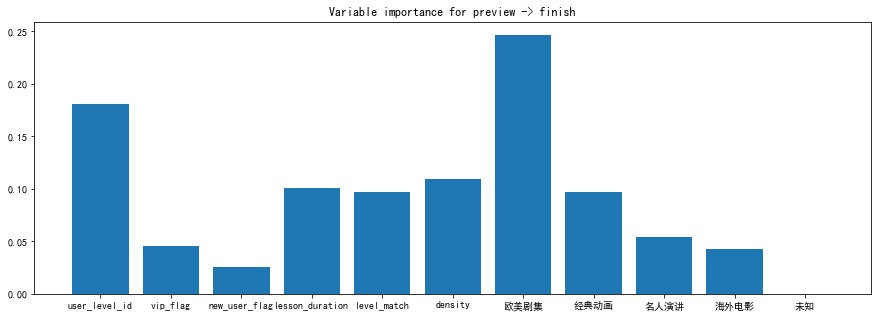

In [209]:
x = new_data[x_var + dummy_var]
y = new_data[y_var]

model = XGBRegressor()
model.fit(x, y)

importance = model.feature_importances_

list_arrays = [np.array(x_var + dummy_var), importance]
df_imp = pd.DataFrame(list_arrays)
plt.figure(figsize=(15, 5))
plt.bar(df_imp.iloc[0], df_imp.iloc[1])
plt.title('Variable importance for preview -> finish')


#### 吸引力探究
##### 作品预览 -> 开始配音

Text(0.5, 1.0, 'Variable importance for preview -> start')

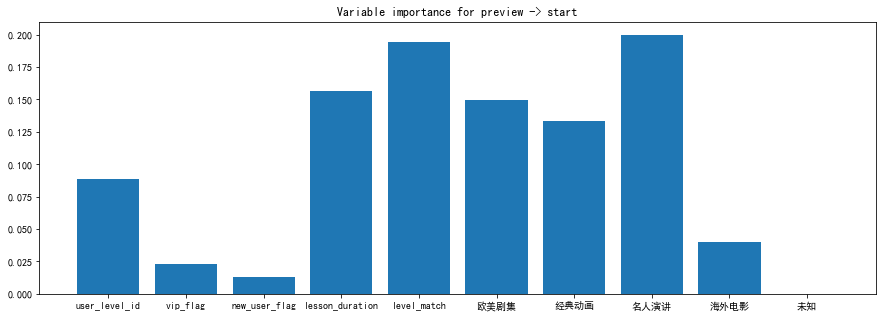

In [211]:
x = new_data[x_var + dummy_var]
y = new_data[y_var]

model = XGBRegressor()
model.fit(x, y)

importance = model.feature_importances_

list_arrays = [np.array(x_var + dummy_var), importance]
df_imp = pd.DataFrame(list_arrays)
plt.figure(figsize=(15, 5))
plt.bar(df_imp.iloc[0], df_imp.iloc[1])
plt.title('Variable importance for preview -> start')
